# Excercise 5: <br /> Train a Model

## Import data

### Load Packages

In [13]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import seaborn as sns

### Load Data into Dataframe

In [14]:
df = pd.read_csv('Building_Permits.csv')

df.dtypes

/var/folders/b4/cdtgtsvd51d_dj86npcvw5500000gn/T/ipykernel_21452/1447638771.py:1: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Building_Permits.csv')


Permit Number                              object
Permit Type                                 int64
Permit Type Definition                     object
Permit Creation Date                       object
Block                                      object
Lot                                        object
Street Number                               int64
Street Number Suffix                       object
Street Name                                object
Street Suffix                              object
Unit                                      float64
Unit Suffix                                object
Description                                object
Current Status                             object
Current Status Date                        object
Filed Date                                 object
Issued Date                                object
Completed Date                             object
First Construction Document Date           object
Structural Notification                    object


In [15]:
df

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198895,M862628,8,otc alterations permit,12/05/2017,0113,017A,1228,NaN,Montgomery,St,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1489337276729
198896,201712055595,8,otc alterations permit,12/05/2017,0271,014,580,NaN,Bush,St,...,5.0,wood frame (5),5.0,wood frame (5),NaN,NaN,NaN,NaN,NaN,1489462354993
198897,M863507,8,otc alterations permit,12/06/2017,4318,019,1568,NaN,Indiana,St,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1489539379952
198898,M863747,8,otc alterations permit,12/06/2017,0298,029,795,NaN,Sutter,St,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1489608233656


## Preprocess Data

In [16]:
# Create a copy of the original dataframe
df_processed = df.copy()

# Example preprocessing
df_processed = df.drop(columns=["Permit Number", "Permit Type Definition", "Unit", "Unit Suffix", "Street Suffix", "Street Number Suffix", "Location", "Record ID"])  # irrelevant for prediction

# Replace missing values for fire only permits
df_processed["Fire Only Permit"] = df_processed["Fire Only Permit"].fillna("N")

# Drop all columns with more than 50% missing values
missing_threshold = 0.5 * len(df_processed)
df_processed = df_processed.loc[:, df.isnull().mean() < missing_threshold]

# Drop samples with more than 50% missing features
df_processed = df_processed[df_processed.isnull().mean(axis=1) < 0.5]

# Convert dates to unix timestamp
for col in df_processed.columns:
    if "Date" in col:
        df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce').astype('int64') // 10**9

# Encode categorical featre into integers
for col in df_processed.select_dtypes(include=["object"]).columns:
    df_processed[col] = pd.Categorical(df_processed[col]).codes

# Target variable
y = df_processed["Permit Type"]
X = df_processed.drop(columns=["Permit Type"])

X

,Permit Creation Date,Block,Lot,Street Number,Street Name,Description,Current Status,Current Status Date,Filed Date,Issued Date,...,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode
0,1430870400,321,343,140,525,42530,5,1513814400,1430870400,1447027200,...,2.0,-1,3.0,2,NaN,-1,-1,3.0,35,94102.0
1,1461024000,300,133,440,635,75441,8,1501718400,1461024000,1501718400,...,2.0,-1,3.0,2,NaN,-1,-1,3.0,35,94102.0
2,1464307200,510,703,1647,1174,51076,13,1506384000,1464307200,-9223372037,...,2.0,-1,1.0,0,1.0,0,-1,3.0,31,94109.0
3,1478476800,145,201,1230,1174,81676,3,1500854400,1478476800,1500336000,...,2.0,-1,5.0,4,5.0,4,-1,3.0,20,94109.0
4,1480291200,337,1,950,992,33513,8,1512086400,1480291200,1512086400,...,2.0,-1,3.0,2,NaN,-1,-1,6.0,35,94102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198891,1511740800,670,151,590,1579,98778,8,1512691200,1511740800,1512691200,...,2.0,-1,3.0,2,3.0,2,-1,NaN,-1,NaN
198892,1512345600,1025,318,1543,1010,107377,8,1516060800,1512345600,1516060800,...,2.0,-1,5.0,4,5.0,4,-1,NaN,-1,NaN
198893,1512432000,863,231,3018,354,25063,3,1516579200,1512432000,1512432000,...,0.0,-1,5.0,4,5.0,4,-1,NaN,-1,NaN
198894,1512432000,2673,114,340,15,94955,8,1512432000,1512432000,1512432000,...,0.0,-1,5.0,4,5.0,4,-1,NaN,-1,NaN


## Split Data

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.98      0.94      0.96        67
           2       0.99      0.99      0.99       185
           3       0.97      0.73      0.83      2941
           4       0.99      1.00      1.00       570
           5       0.78      0.81      0.79        26
           6       0.99      0.96      0.97       120
           7       0.93      0.99      0.96        85
           8       0.97      1.00      0.98     28144

    accuracy                           0.97     32138
   macro avg       0.95      0.93      0.94     32138
weighted avg       0.97      0.97      0.97     32138



In [19]:
from joblib import dump

# Save the trained model to a file
dump(clf, 'trained_model.joblib')

['trained_model.joblib']

## Evaluation

| Label | Precision | Recall | F1-score | Support | Interpretation                                                           |
| ----- | --------- | ------ | -------- | ------- | ------------------------------------------------------------------------ |
| **1** | 0.98      | 0.94   | 0.96     | 67      | Excellent, very few misclassifications                                   |
| **2** | 0.99      | 0.99   | 0.99     | 185     | Outstanding performance                                                  |
| **3** | 0.97      | 0.73   | 0.83     | 2941    | ⚠️ High precision, but lower recall → many were missed (under-predicted) |
| **4** | 0.99      | 1.00   | 1.00     | 570     | Perfect classification                                                   |
| **5** | 0.78      | 0.81   | 0.79     | 26      | Lower metrics likely due to small sample size                            |
| **6** | 0.99      | 0.96   | 0.97     | 120     | Very strong result                                                       |
| **7** | 0.93      | 0.99   | 0.96     | 85      | Slight under-prediction, but still excellent                             |
| **8** | 0.97      | 1.00   | 0.98     | 28,144  | Dominant class, extremely well predicted                                 |


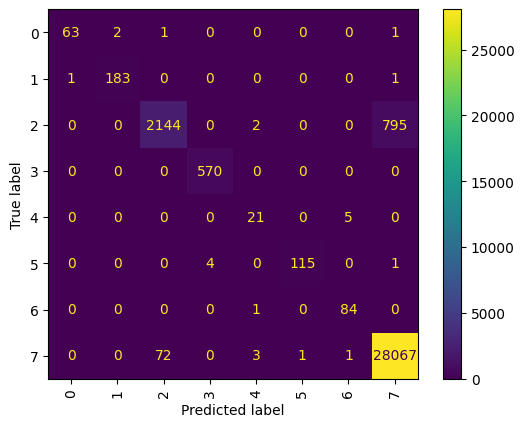

In [20]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation="vertical")
plt.show()

The value at (2, 2) is 2144, meaning:
2,144 permits were correctly predicted as type 2.

The value at (2, 7) is 795, meaning:
795 permits were actually type 2, but your model predicted them as type 7.

| Class | Support | Correct | Main Confusion              |
| ----- | ------- | ------- | --------------------------- |
| 0     | 69      | 63      | minor confusion (1, 2)      |
| 1     | 185     | 183     | great result                |
| 2     | 2939    | 2144    | \~27% predicted as 7        |
| 3     | 570     | 570     | perfect                     |
| 4     | 26      | 21      | some confusion with 5       |
| 5     | 120     | 115     | slightly confused with 2, 4 |
| 6     | 85      | 84      | great result                |
| 7     | 28144   | 28067   | excellent                   |


# Try Variations

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Create pipeline: Impute missing values -> Scale -> MLP
mlp_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
])

# Fit and evaluate
mlp_pipeline.fit(X_train, y_train)
y_pred_mlp = mlp_pipeline.predict(X_test)

print("=== Neural Network (MLPClassifier with Imputation) ===")
print(classification_report(y_test, y_pred_mlp))


=== Neural Network (MLPClassifier with Imputation) ===
              precision    recall  f1-score   support

           1       0.86      0.90      0.88        67
           2       0.97      0.95      0.96       185
           3       0.76      0.76      0.76      2941
           4       0.97      0.98      0.97       570
           5       0.68      0.73      0.70        26
           6       0.88      0.88      0.88       120
           7       0.96      0.96      0.96        85
           8       0.97      0.97      0.97     28144

    accuracy                           0.95     32138
   macro avg       0.88      0.89      0.89     32138
weighted avg       0.95      0.95      0.95     32138



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred_scaled = pipeline.predict(X_test)
print("=== Random Forest with Scaled Features ===")
print(classification_report(y_test, y_pred_scaled))


=== Random Forest with Scaled Features ===
              precision    recall  f1-score   support

           1       0.98      0.93      0.95        67
           2       0.98      0.99      0.99       185
           3       0.97      0.73      0.83      2941
           4       0.99      1.00      1.00       570
           5       0.81      0.81      0.81        26
           6       0.99      0.97      0.98       120
           7       0.93      0.99      0.96        85
           8       0.97      1.00      0.98     28144

    accuracy                           0.97     32138
   macro avg       0.95      0.93      0.94     32138
weighted avg       0.97      0.97      0.97     32138

